In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, precision_score, recall_score, accuracy_score
import math

In [2]:
import os
import sys

train_path, validation_path, test_path = "", "", ""

# Function to detect the environment
def detect_environment():
    # Check if Google Colab
    try:
        import google.colab
        return 'colab'
    except ImportError:
        pass
    
    # Check if Jupyter Notebook
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return 'jupyter'
        elif shell == 'TerminalInteractiveShell':
            return 'terminal'
        else:
            return 'other'
    except NameError:
        return 'other'

# Set paths based on the detected environment
env = detect_environment()

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    
    train_path = "/content/drive/MyDrive/fullset_train.csv"
    validation_path = "/content/drive/MyDrive/fullset_validation.csv"
    test_path = "/content/drive/MyDrive/fullset_test.csv"
elif env == 'jupyter':
    train_path = "../Dataset/fullset_train.csv"
    validation_path = "../Dataset/fullset_validation.csv"
    test_path = "../Dataset/fullset_test.csv"
else:
    print("Unknown environment. Please set paths manually.")

# Use the DATA_PATH in your code
if train_path:
    print(f"train path is set to: {train_path}")
else:
    print("train_path is not set. Please check your environment settings.")


train path is set to: ../Dataset/fullset_train.csv


In [3]:
# device detection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [4]:
# HYPERPARAMETERS
n_bases = 4

isWeighted = True
pos_weights_ratio = 1
batch_size = 256
learning_rate = 1e-3
n_epochs = 100

threshold = 0.80

loss_info_ratio = 1

In [5]:
# GPU dataset version (immediately moves the data on GPU to enanche performaces)
def convert_string_sequence_into_array(sequence):
    """Transforms a string into a numpy array of one-hot encoded data
    
    Parameters
    ----------
    sequence: str
        input DNA sequence as string

    Returns
    -------
    numpy.ndarray
        the one-hot encoded DNA sequence as an array
    """
    result = np.zeros(shape=(1, n_bases, len(sequence)))
    base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    for idx, base in enumerate(sequence.upper()):
        result[0, base_dict[base], idx] = 1
    return result

class DNADatasetForGPU(Dataset):
    """Dataset built for performance
    The previous versions used specific transformations, as shown in
    https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html
    but this massively slowed the computation time when we switched to the actual architecture

    The actual dataset processes every tensor at "first-reading time", and moves it to the current device directly if needed.
    """
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path, header=0, names=['seq_id', 'sequence', 'label'])

        self.y = torch.tensor(df['label'].values).float().view(-1, 1).to(device)
        self.x = torch.tensor(
            np.array([convert_string_sequence_into_array(seq) for seq in df['sequence']])
        ).float().to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [15]:
# DATASET EXTRACTION
train_dataset = DNADatasetForGPU(train_path)

val_dataset = DNADatasetForGPU(validation_path)

test_dataset = DNADatasetForGPU(test_path)

print(len(train_dataset), len(val_dataset), len(test_dataset))

# calculating the ratio between the classes
if isWeighted:
    n_pos_examples = (train_dataset.y == 1).sum().item()
    n_neg_examples = len(train_dataset) - n_pos_examples
    
    fake_weight = n_neg_examples / float(n_pos_examples)
    general_weight = n_pos_examples / float(len(train_dataset))
    
    fake_weight_tensor = torch.tensor([fake_weight]).to(device)
    general_weight_tensor = torch.tensor([general_weight]).to(device)

    print("fake_weight:", fake_weight_tensor.item())
    print("fake_weight tensor size:", fake_weight_tensor.shape)
    print("general_weight:", general_weight_tensor.item())
    print("general_weight tensor size:", general_weight_tensor.shape)

211238 26404 26404
fake_weight: 46.29914855957031
fake_weight tensor size: torch.Size([1])
general_weight: 0.021142030134797096
general_weight tensor size: torch.Size([1])


In [17]:
if isWeighted:
    # testing that is a probability
    neg_weight = general_weight
    pos_weight = general_weight * fake_weight
    print("neg_weight:", neg_weight)
    print("pos_weight:", pos_weight)
    print("Summation:", neg_weight + pos_weight)

neg_weight: 0.021142029369715674
pos_weight: 0.9788579706302843
Summation: 1.0


In [8]:
# Dataloader declarations
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# model definition
class AttentionBlock(nn.Module):
    """Attention Block
    Used in the original attention model (the best one)
    """
    def __init__(self, input_dim, hidden_dim):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        attention_weights = torch.softmax(self.attention(x).squeeze(-1), dim=-1)
        return torch.sum(x * attention_weights.unsqueeze(-1), dim=1)

class AttentionBlockQKV(nn.Module):
    """Attention Block (with Query, Key, Value)
    Implemented as in the slides
    """
    def __init__(self, input_dim, embedded_dim):
        super(AttentionBlockQKV, self).__init__()
        
        self.query = nn.Linear(input_dim, embedded_dim)
        self.key = nn.Linear(input_dim, embedded_dim)
        self.value = nn.Linear(input_dim, embedded_dim)
        self.attention = nn.MultiheadAttention(embedded_dim, 1, batch_first=True)

    def forward(self, x):
        # computing the matrices
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attn_out, _ = self.attention(Q, K, V)
        return attn_out

class EnhancedVirusModel2(nn.Module):
    """Updated net version (use this even for change something)"""
    def __init__(self, maps=128, hidden=64):
        super(EnhancedVirusModel2, self).__init__()
        self.maps = maps
        
        self.conv = nn.Conv2d(1, maps, kernel_size=(4, 5))
        self.batch_norm = nn.BatchNorm2d(maps)
        self.relu = nn.ReLU()
        self.max = nn.MaxPool2d(kernel_size=(1, 2))
        self.lstm = nn.LSTM(maps, hidden, bidirectional=True, batch_first=True)
        #self.gru = nn.GRU(maps, hidden, bidirectional=True, batch_first=True)
        self.attention = nn.MultiheadAttention(hidden * 2, 1, batch_first=True) # (hidden*2, hidden)
        self.linear = nn.Linear(hidden * 2 * 148, 1)
        #self.linear = nn.Sequential(
        #    nn.Linear(hidden * 148, tail),
        #    nn.ReLU(),
        #    #nn.Dropout(0.2),
        #    nn.Linear(tail, 1)
        #)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional block
        x = self.relu(self.batch_norm(self.conv(x)))
        x = self.max(x)
        x = self.dropout(x)
        
        # size [batch_size, self.maps, 1, 148] into [batch_size, 148, self.maps]
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        # LSTM and Attention block
        x, _ = self.lstm(x) # output size [batch_size, 148, hidden * 2]
        #x, _ = self.gru(x)
        x, _ = self.attention(x, x, x) # output size [batch_size, 148, hidden * 2]
        x = self.dropout(x)

        # concat the output of the Attention block into the final linear layer
        x = x.reshape(x.size(0), -1)
        x = self.linear(x)

        return x

In [10]:
# MODEL DECLARATION
model = EnhancedVirusModel2().to(device)

def init_weights(layer):
    """Initialize weights for the model"""
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)

model.attention.apply(init_weights)
model.linear.apply(init_weights)

Linear(in_features=18944, out_features=1, bias=True)

In [11]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in train loop after loss.backwards() as 
    "plot_grad_flow(model.named_parameters())" to visualize the gradient flow'''
    print("Plotting...")
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
            max_grads.append(p.grad.abs().max().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()

In [12]:
# loss and optimizer definition
if isWeighted:
    criterion = nn.BCEWithLogitsLoss(weight=general_weight_tensor, pos_weight=fake_weight_tensor)
else:
    criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr=learning_rate*100, mode='triangular2')

In [13]:
# loops definition
def train_loop(dataloader, model, criterion, optimizer, loss_list, iter_per_epoch, loss_info_step=0):
    """Train loop
    Performs a single training epoch over the dataset

    Parameters
    ----------
    dataloader: torch.utils.data.dataloader.DataLoader
        dataloader for the current dataset (should be train)
    model: torch.nn.Module
        model to train
    criterion: loss function of pytorch
        loss function used
    optimizer: torch.optim.Optimizer
        algorithm that performs the parameters update
    loss_list: list
        here the function appends each value of the average loss computed each loss_info_step number of iterations (see below)
    iter_per_epoch: positive int
        number of iterations within one epoch
    loss_info_step: positive int (less than iter_per_epochs), optional
        specifies the number of iterations that must pass before appending a new loss value to loss_list. It also specifies the time interval between
        the output printing. If set to 0, no output will be printed and no loss will be stored. (default is 0)
    """
    model.train()
    partial_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):        
        # forward pass and loss computation
        y_pred = model(X)        
        loss = criterion(y_pred, y)
        partial_loss += loss.item()
    
        # backward pass and params update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch + 1) == 50:
            plot_grad_flow(model.named_parameters())

        if loss_info_step != 0 and (batch + 1) % loss_info_step == 0:
            # register loss for the plot
            avg_loss = partial_loss / float(loss_info_step)
            loss_list.append(avg_loss)
            partial_loss = 0

            # print some infos
            print(f"Iteration {batch + 1}/{iter_per_epoch}: avg_loss = {avg_loss:.6f}")

def validation_loop(dataloader, model, criterion, loss_list, threshold=0.5, loss_info_step=0):
    """Evaluation loop
    Performs a single validation/test epoch over the dataset (evaluates the performaces)

    Parameters
    ----------
    dataloader: torch.utils.data.dataloader.DataLoader
        dataloader for the current dataset (should be validation or test)
    model: torch.nn.Module
        model to evaluate
    criterion: loss function of pytorch
        loss function used
    loss_list: list
        here the function appends each value of the average loss computed each loss_info_step number of iterations (see below)
    iter_per_epoch: positive int
        number of iterations within one epoch
    threshold: [0, 1] float, optional
        threshold value (defualt is 0.5)
    loss_info_step: positive int (less than iter_per_epochs), optional
        specifies the number of iterations that must pass before appending a new loss value to loss_list. It also specifies the time interval between
        the output printing. If set to 0, no output will be printed and no loss will be stored. (default is 0)

    Returns
    -------
    tuple
        a tuple containing all the predictions and all the labels respectively as numpy.ndarray
    """
    model.eval()
    total_loss = 0
    partial_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # forward pass and loss computation
            y_pred = model(X)
            loss = criterion(y_pred, y)
            total_loss += loss.item()
            partial_loss += loss.item()

            # class prediction
            prob_pred = nn.functional.sigmoid(y_pred)
            #class_pred = prob_pred > threshold

            # reporting results
            all_preds.extend(prob_pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            if loss_info_step != 0 and (batch + 1) % loss_info_step == 0:
                # register loss for the plot
                avg_loss = partial_loss / float(loss_info_step)
                loss_list.append(avg_loss)
                partial_loss = 0

    # compute metrics
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    pred_labels = (all_preds > threshold).astype(int)
    
    accuracy = accuracy_score(all_labels, pred_labels)
    precision = precision_score(all_labels, pred_labels, zero_division=0.0)
    recall = recall_score(all_labels, pred_labels, zero_division=0.0)
    
    avg_loss = total_loss / len(dataloader)
    
    print(f"Validation Accuracy: {accuracy:.4f}, Average Loss: {avg_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    return all_preds, all_labels

Epoch 1 -------------
Plotting...


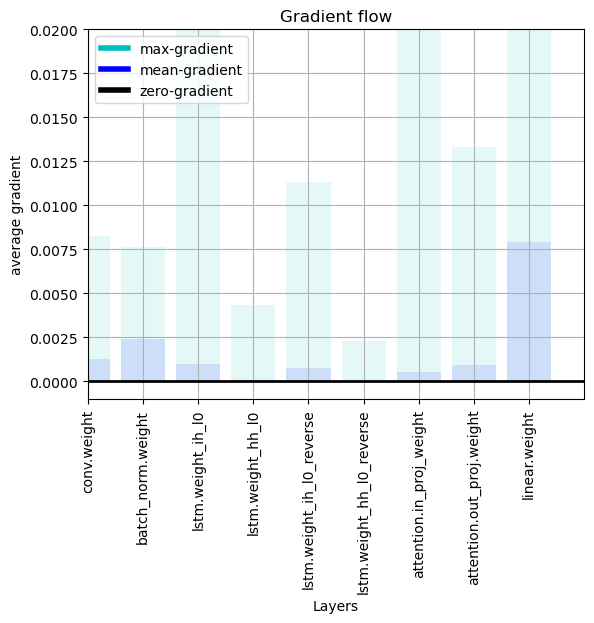

Iteration 826/826: avg_loss = 1.275232
Validation Accuracy: 0.9559, Average Loss: 1.1135, Precision: 0.0720, Recall: 0.0993
Epoch 2 -------------
Plotting...


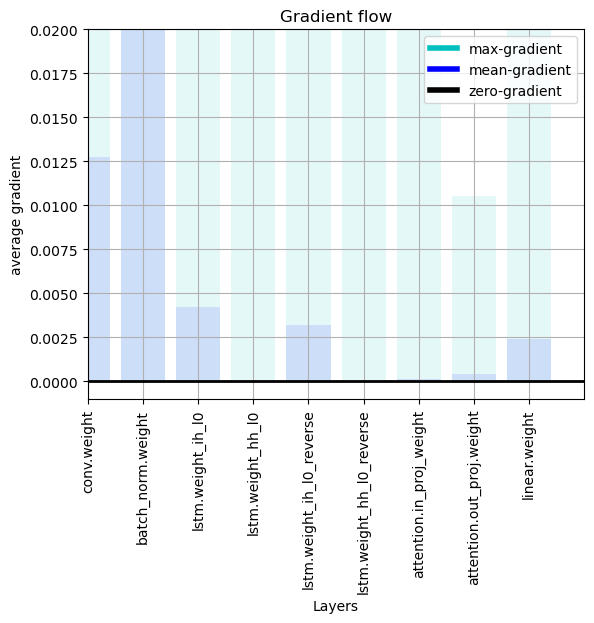

KeyboardInterrupt: 

In [14]:
###### MAIN LOOP
iter_per_epoch_train = math.ceil(len(train_dataset) / float(batch_size))
iter_per_epoch_val = math.ceil(len(val_dataset) / float(batch_size))
loss_info_step_train = math.floor(iter_per_epoch_train * loss_info_ratio)
loss_info_step_val = math.floor(iter_per_epoch_val * loss_info_ratio)

best_val_loss = float('inf')
patience = 5

train_loss_list = []
val_loss_list = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1} -------------")
    train_loop(train_dataloader, model, criterion, optimizer, train_loss_list, iter_per_epoch_train, loss_info_step=loss_info_step_train)
    validation_loop(val_dataloader, model, criterion, val_loss_list, threshold=threshold, loss_info_step=loss_info_step_val)

    scheduler.step()

    torch.save(model.state_dict(), '../Models/best_model_EnhancedVirusModel.pth')
    """
    if val_loss_list[-1] < best_val_loss:
        best_val_loss = val_loss_list[-1]
        counter = 0
        torch.save(model.state_dict(), '../Models/best_model_EnhancedVirusModel.pth')
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping")
        break
    """

Iterations doesn't match. Printing row data
Epochs doesn't match. Printing row data


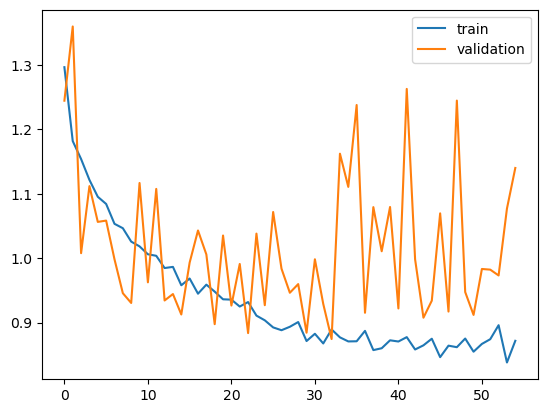

In [15]:
# PLOT LOSS TRAIN/VALIDATION
iteration_ax = np.linspace(0, n_epochs, n_epochs * math.floor(1 / loss_info_ratio)).tolist()
epoch_ax = np.linspace(0, n_epochs, n_epochs * math.floor(1 / loss_info_ratio)).tolist()

if len(iteration_ax) == len(train_loss_list):
    plt.plot(iteration_ax, train_loss_list, label='train')
else:
    print("Iterations doesn't match. Printing row data")
    plt.plot(train_loss_list, label='train')

if len(epoch_ax) == len(val_loss_list):
    plt.plot(epoch_ax, val_loss_list, label='validation')
else:
    print("Epochs doesn't match. Printing row data")
    plt.plot(val_loss_list, label='validation')

plt.legend()
plt.show()

In [62]:
# load best model for the evaluation (due to early stopping)
model.load_state_dict(torch.load('../Models/best_model_EnhancedVirusModel.pth'))

C:\Users\Matteo Ruta\AppData\Local\Temp\ipykernel_24508\3291173247.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../Models/best_model

<All keys matched successfully>

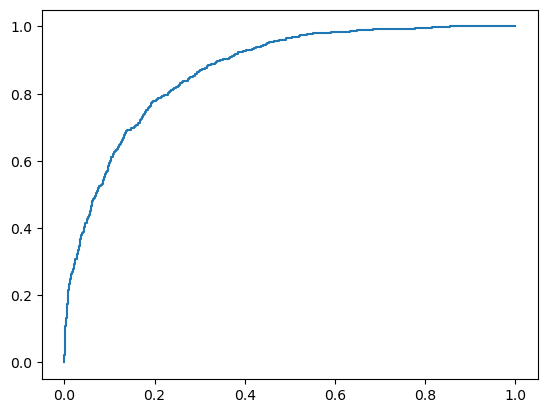

In [63]:
# computing ROC curve using sklearn.metrics
# with this implementation, we repeat the same validation_loop we did in the last epoch
# maybe this thing could be done better
model.eval()
ground_truth = val_dataset.y.cpu().numpy()
pred_probabilities = []
#pred_probabilities = torch.Tensor.numpy(nn.Sigmoid()(model(validation_dataset.features)).cpu())

with torch.no_grad():
    for X, y in val_dataloader:
        #X = X.to(device)
        #y = y.to(device)
        
        y_pred = model(X)
        prob_pred = nn.functional.sigmoid(y_pred)

        pred_probabilities.extend(prob_pred.cpu().numpy())

pred_probabilities = np.array(pred_probabilities)

fpr, tpr, thresholds = roc_curve(ground_truth, pred_probabilities)

plt.plot(fpr, tpr)
plt.show()

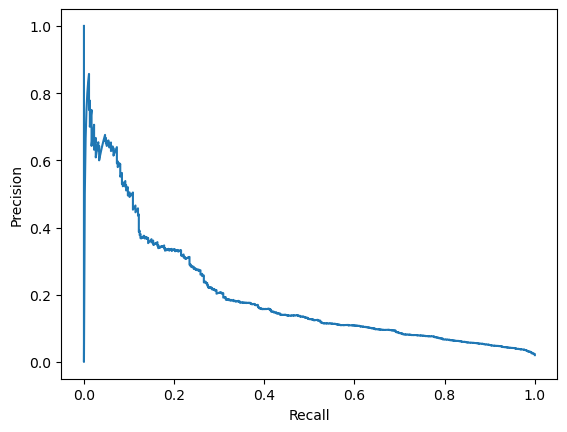

In [64]:
precision, recall, pr_thresholds = precision_recall_curve(ground_truth, pred_probabilities)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [65]:
selected_precision = 0.3
target = np.argmin(abs(precision - selected_precision))
threshold = pr_thresholds[target]
print("Selected threshold:", threshold)

Selected threshold: 0.8694637


C:\Users\Matteo Ruta\AppData\Local\Temp\ipykernel_24508\3620657524.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['Predicted Positive', 'Predicted Negative'])
C:\Users\Matteo Ruta\AppData\Local\Temp\ipykernel_24508\3620657524.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ['Actual Positive', 'Actual Negative'])


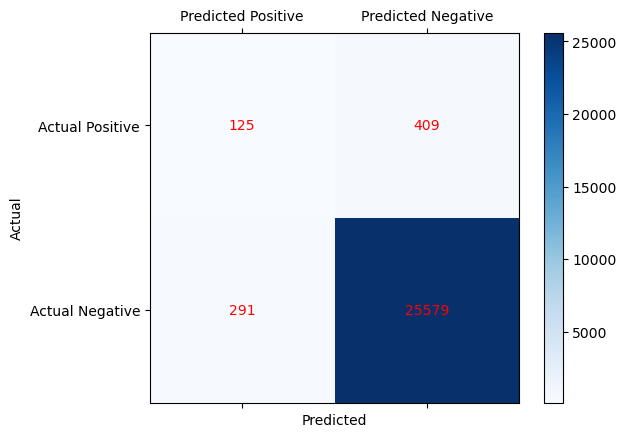

In [66]:
cm = confusion_matrix(ground_truth, (pred_probabilities > threshold).astype(int))
# cm shape
# [[TN, FP]
#  [FN, TP]]
cm = np.flip(cm)

# Plotting the confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Annotate the matrix with the counts
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='red')

# Set labels
ax.set_xticklabels([''] + ['Predicted Positive', 'Predicted Negative'])
ax.set_yticklabels([''] + ['Actual Positive', 'Actual Negative'])

# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show plot
plt.show()